# Minionology: HVSR with seismic nodes
### Skience2023 practical on HVSR, node installation, applications, Geopsy, continuous data analysis

##### Authors:
* Koen Van Noten ([@KoenVanNoten](https://github.com/KoenVanNoten))
* Thomas Lecocq ([@seismotom](https://github.com/ThomasLecocq)

## Exercise 3:  
## The nature of the Bayrischzell valley infill
In this exercise, we will do a similar analysis as in Brussels (ex1), but now with data gathered along the Leitzach river valley, W of Bayrischzell. These seismic dataset was gathered between Sunday 27/02/2023 and Monday 28/03/2023 by Koen, Tom and Raph who installed 12 SmartSolo nodes across the valley. See red dashed line in the figure below.

##### Purpose
Analyse the ambient noise recordings either using Geopsy manually and making a cross-profile (see ex 1), or using an automatic analysis (ex. 2) to investigate the valley infill.

##### Data interpretation
To make an interpretation of the data, it is useful to have a look to the local geological map of Bayrischzel, which can be consulted here: 
https://www.bestellen.bayern.de/application/pictureSrv?SID=3274027&ACTIONxSESSxSHOWPIC(BILDxKEY:%2712052%27,BILDxCLASS:%27Artikel%27,BILDxTYPE:%27BildGross%27)=Z

and here:
https://www.bestellen.bayern.de/application/pictureSrv?SID=3274027&ACTIONxSESSxSHOWPIC(BILDxKEY:%2712052%27,BILDxCLASS:%27Artikel%27,BILDxTYPE:%27BildGross%27)=Z

__Infill Geology__:
* Postglacial Schoffer (Sand und Schoffer)
* Local morene mitt Wallform

__Bedrock Geology__:
* Hauptdolomite (HD)

<img src="Figures/Bayrischzell valley.png" width=800></img>

The seismic dataset gathered Bayrischzell can be downloaded here:
__TO DO__

Before playing with the HVSR data, let's have a look on data gathered.

### 0. Prequel: elevation data
First, read the topography cross-profile _'Barischzell_crossprofile.csv'_ in folder __in HVSR_ex3_Bay\__  

Plot it along distance using the cumulative distance with respect to 1st point. The first point is the most northern point in the valley.

Text(0.5, 1.0, 'Bayrischzell HV profile')

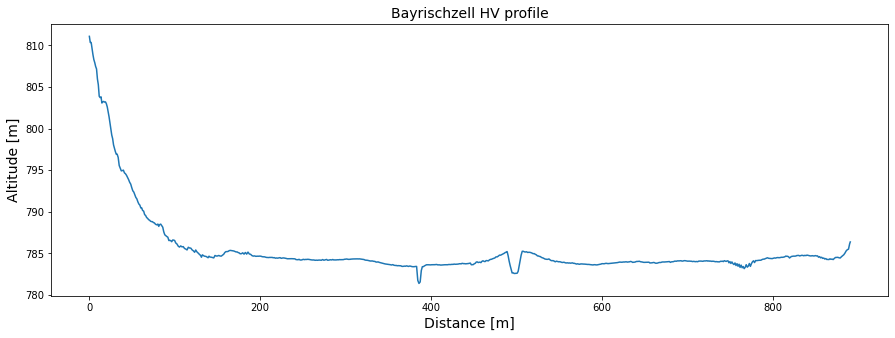

In [20]:
profile = r'HVSR_ex3_Bay\Barischzell_crossprofile.csv'
df_profile = pd.read_csv(profile)
lat_profile = df_profile['Lat']
lon_profile = df_profile['Lon']
Z_profile = df_profile["Z"]

# compute inter_distances
inter_distances = []
for nr in np.arange(0,len(df_profile)-1,1):
    inter_distances.append(gps2dist_azimuth(lat_profile[nr], lon_profile[nr], lat_profile[nr+1],lon_profile[nr+1])[0])
inter_distances = pd.Series(inter_distances)

# open a series, but start with distance 0
cumul = pd.Series([0])
# add the cumulative distances to the cumul list
d_cumul_profile = pd.concat([cumul,inter_distances.cumsum()], ignore_index = True)
#d_cumul

#inter_distances
fig, ax= plt.subplots(figsize=(15,5))
plt.plot(d_cumul_profile,Z)
plt.ylabel('Altitude [m]', fontsize = 14)
plt.xlabel('Distance [m]', fontsize = 14)
plt.title('Bayrischzell HV profile', fontsize = 14)

### Let's start
Activate the necessary modules/def's first.

In [5]:
import pandas as pd
import numpy as np
import obspy
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
from obspy.imaging.scripts.scan import Scanner
from obspy.geodetics.base import gps2dist_azimuth 
from scipy.interpolate import interp1d

# run the previous notebook
%run 00_HVSR_Minionology_definitions.ipynb

Scan the data 

C:\Users\koenvn\AppData\Roaming\Python\Python37\site-packages\obspy\imaging\scripts\scan.py:392: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.set_ylim(0 - 0.5, len(labels) - 0.5)


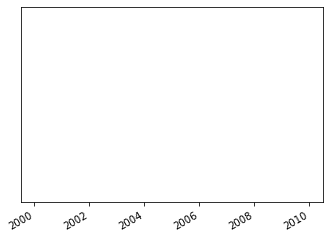

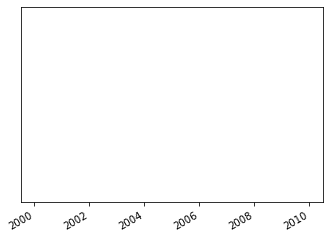

In [22]:
scanner = Scanner()
scanner.parse("HVSR_ex3_Bay")  
scanner.plot() 

### 1. Manual geopsy HVSR dataprocessing
In the first solution, solve the HV data in Geopsy manually and save the .hv file

Use following parameters (or play with them):
* __Length__: 120s
* __Overlap__: 50%
* __Relative treshhold__: 70%
* __Taper__: 5% Tukey
* __Konno-Omachi smoothing__: 40%
* __Squared Average__
* __Output__: 0.20Hz - 50 Hz
* __Step Count__: 500

After computation, manually clean the H/V curve by _Reject time windows_ (right click on the graph) and select those curves that deviate from the mean curve. Then recompute the H/V curve by pressing the black arrow next to _select_ -> _clear_ -> _Remove grayed_ and press _Start_ again.

To save the .HV results do a _Tools_ -> _Save Results_ and save it in the  __HVSR_ex3_Bay\Analysed__ folder

47.68449747


### 2. Reading theBayrischzell HVSR database file
All the node metadata information has been preloaded in an HVSR database file. The HVSR database file is available in the __HVSR_ex3_Bay__ folder.

In [34]:
HV_database = r'HVSR_ex3_Bay\HVSR_database_Bayrischzell.csv'
HV_basefolder, HV_db_name = os.path.split(HV_database)[0], os.path.split(HV_database)[1]
print(HV_basefolder, HV_db_name)

HVSR_ex3_Bay HVSR_database_Bayrischzell.csv


Load the HVSR database into a pandas database. 

In [35]:
db_HVSR = pd.read_csv(HV_database, encoding='latin')
db_HVSR.head()

,Comment,Device number,H/V,Start,End,Lat,Lon,UTM-X,UTM-Y,Z,ID
0,Bayrischzell_HV,453000039,HV01,2023026T15:00:00,2023027T17:00:00,47.684103,11.993158,148669.7449,172774.0343,16.0,BE_00039
1,Bayrischzell_HV,453000270,HV02,2023026T15:00:00,2023027T17:00:00,47.683891,11.992989,148628.7192,172802.6156,16.0,BE_00270
2,Bayrischzell_HV,453000337,HV03,2023026T15:00:00,2023027T17:00:00,47.683099,11.993038,148587.6935,172831.1969,17.0,BE_00337
3,Bayrischzell_HV,453000390,HV04,2023026T15:00:00,2023027T17:00:00,47.682693,11.992942,148546.6678,172859.7781,17.0,BE_00390
4,Bayrischzell_HV,453000617,HV05,2023026T15:00:00,2023027T17:00:00,47.682191,11.992882,148374.8548,173016.2865,18.7,BE_00617


Compute the distance of each node to the first node using the Obspy _obspy.geodetics.base.gps2dist_azimuth_ function and load it to an inter_distance array

inter_distance = [] 

In [36]:
from obspy.geodetics.base import gps2dist_azimuth 

lat = db_HVSR['Lat']
lon = db_HVSR['Lon']

inter_distances = []
for nr in np.arange(0,len(db_HVSR)-1,1):
    inter_distances.append(gps2dist_azimuth(lat[nr], lon[nr], lat[nr+1],lon[nr+1])[0])
inter_distances = pd.Series(inter_distances)
inter_distances

0     26.844087
1     88.097306
2     45.675598
3     56.009246
4     56.009244
5     56.009243
6     56.009241
7     56.009240
8     56.009238
9     56.009237
10    56.009236
dtype: float64

Make a cumulative distance series (d_cumul) with _pd.series.cumsum()_

d_cumul value of the first node is distance to the first node of the Bayrischzell profile. Compute this distance and add that  as first distance to d_cumul with pd.concat 

In [37]:
#distance of first node to first point of the profile
d_first_node = gps2dist_azimuth(lat_profile[0], lon_profile[0], lat[0],lon[0])[0]
print(lat_profile[0], lon_profile[0], lat[0], lon[0])
print(d_first_node)

# open a series, and add the first node distance to it 
cumul = pd.Series(d_first_node)

# add the cumulative distances + d_first_node to the cumul list
d_cumul = pd.concat([cumul,inter_distances.cumsum()+d_first_node], ignore_index = True)
d_cumul

47.68449747 11.99352268 47.68410321 11.99315837
51.66906616819253


0      51.669066
1      78.513154
2     166.610460
3     212.286058
4     268.295303
5     324.304547
6     380.313790
7     436.323031
8     492.332271
9     548.341510
10    604.350747
11    660.359982
dtype: float64

Add the cumulative distance column to the pandas dataframe

In [38]:
db_HVSR['d_cumul'] = d_cumul
db_HVSR.head()

,Comment,Device number,H/V,Start,End,Lat,Lon,UTM-X,UTM-Y,Z,ID,d_cumul
0,Bayrischzell_HV,453000039,HV01,2023026T15:00:00,2023027T17:00:00,47.684103,11.993158,148669.7449,172774.0343,16.0,BE_00039,51.669066
1,Bayrischzell_HV,453000270,HV02,2023026T15:00:00,2023027T17:00:00,47.683891,11.992989,148628.7192,172802.6156,16.0,BE_00270,78.513154
2,Bayrischzell_HV,453000337,HV03,2023026T15:00:00,2023027T17:00:00,47.683099,11.993038,148587.6935,172831.1969,17.0,BE_00337,166.610460
3,Bayrischzell_HV,453000390,HV04,2023026T15:00:00,2023027T17:00:00,47.682693,11.992942,148546.6678,172859.7781,17.0,BE_00390,212.286058
4,Bayrischzell_HV,453000617,HV05,2023026T15:00:00,2023027T17:00:00,47.682191,11.992882,148374.8548,173016.2865,18.7,BE_00617,268.295303


### 3. Filling the HVSR database file with .hv data

By using Geopsy, the HVSR data has been saved as .hv files in the _HVSR_ex1_Bru\Analysed_ folder. We will extract and add it to the HVSR database. The script in below (Van Noten _et al._ 2022) reads the HVSR database and extracts all the necessary data in the .hv files being:

* __f0 min__: f0_win/stddev (from GEOPSY)
* __f0_win__: average resonance frequency by taking the f0 of each individual window and averaging all f0 values from these windows (from GEOPSY)
* __f0 average__: scanning the average curve and identifying the frequency at which the maximum amplitude occurs (from GEOPSY)
* __f0_ip__: resonance frequency computed after interpolating the HV-Amplitude graph using python. This is useful if you forgot to adapt the Step Count
* __f0_ip_diff__: difference between f0_ip and f0_win
* __error__: standard deviation on f0 (from GEOPSY)
* __f0 max__: f0_win.stddev (from GEOPSY)
* __A0__: maximum amplitude (from GEOPSY)
* __nw__: number of windows (from GEOPSY)

Reference:
https://github.com/KoenVanNoten/HVSR_to_virtual_borehole/blob/master/Get%20f0s%20from%20geopsy%20hv%20files.py

In [39]:
database_file = HV_database
db_HVSR.head()

,Comment,Device number,H/V,Start,End,Lat,Lon,UTM-X,UTM-Y,Z,ID,d_cumul
0,Bayrischzell_HV,453000039,HV01,2023026T15:00:00,2023027T17:00:00,47.684103,11.993158,148669.7449,172774.0343,16.0,BE_00039,51.669066
1,Bayrischzell_HV,453000270,HV02,2023026T15:00:00,2023027T17:00:00,47.683891,11.992989,148628.7192,172802.6156,16.0,BE_00270,78.513154
2,Bayrischzell_HV,453000337,HV03,2023026T15:00:00,2023027T17:00:00,47.683099,11.993038,148587.6935,172831.1969,17.0,BE_00337,166.610460
3,Bayrischzell_HV,453000390,HV04,2023026T15:00:00,2023027T17:00:00,47.682693,11.992942,148546.6678,172859.7781,17.0,BE_00390,212.286058
4,Bayrischzell_HV,453000617,HV05,2023026T15:00:00,2023027T17:00:00,47.682191,11.992882,148374.8548,173016.2865,18.7,BE_00617,268.295303


In [40]:
# read the database file in which all the names of the .hv measurements are stored
HV_folder = os.path.join(HV_basefolder, 'Analysed')  #folder containing all .hv data

# create a copy of the HVSR database 
outputfile = db_HVSR

#### Initializing empty columns that need to be filled from the Geopsy .hv files
for _ in ["f0_min", "f0_win", "f0_average", "f0_ip", "f0_ip_diff", "error", "f0_max", "A0", "nw"]:
    outputfile[_] = 0.

output = []

#### loop through each .hv datafile
for id, row in outputfile.iterrows():
    HV_file = os.path.join(HV_folder, row["ID"] + ".hv")
    print(HV_file)
    df = pd.read_csv(HV_file, nrows=5, skiprows=1, header=None) #opening the .hv file
    rows = ["num", "f0_avg", "num_f0", "f0s", "peak_amp"] #define rows to write in the output file
    data = {}
    for row in rows:
        data[row] = ""
    delims = ["=", "\t", "=", "\t", "\t"]
    for id2, item in df.iterrows():
        XXX = item[0].split(delims[id2])
        data[rows[id2]] = np.asarray(XXX[1:], dtype=float).flatten()
    data["f0_win"], data["f_min"], data["f_max"] = data["f0s"]
    del data["f0s"]
    data["error"] = data["f0_win"] - data["f_min"]
    data["f0_avg"] = data["f0_avg"][0]
    data["peak_amp"] = data["peak_amp"][0]
    data["num"] = data["num"][0]
    data["num_f0"] = data["num_f0"][0]

    # In the default setting, Geopsy only exports 100 frequency-amplitude samples for the computed HVSR curve.
    # One can increase this number by:
    #   - either increasing the sample numbers in geopsy (max = 9999)
    #   - or by interpolating between the samples and improve the accuracy of picking f0 (this script)
    # Increasing the samples in Geopsy to 9999 gives the same results, but one might have forgotten to do this while processing
    # so this interpolation offers a nice twist to solve this.

    # The part in below executes the interpolation up to 15000 samples
    # See paper Van Noten et al. for more information. Same method is applied in the HVSR_to_virtual_borehole module
    HV_data = np.genfromtxt(HV_file, delimiter='\t', usecols=(0, 1))
    f_orig = HV_data[:, 0] #original frequency data
    print("nr of samples:", len(f_orig))
    A_orig = HV_data[:, 1] #original amplitude data
    func = interp1d(f_orig, A_orig, 'cubic') #IN
    f_new = np.linspace(f_orig[0], f_orig[-1], 15000) #interpolation for 15000 samples
    A_new = func(f_new) #defining the function for the new Amplitude
    maxx = np.argmax(A_new)

    # With the interpolated data new columns can be calculated to compare the interpolated values and the ones provided by Geopsy
    f0_ip_diff = f_new[maxx] - data["f0_win"] #difference between f0_interpolated and f0_geopsy

    #write all data to the database file
    outputfile.loc[id, "f0_min"] = data["f_min"] #f0 min
    print("f0_min:", round(data["f_min"],3), "Hz")
    outputfile.loc[id, "f0_win"] = data["f0_win"] #average f0 computed by averaging the peak f0 values of all individual windows
    print("f0_win:", round(data["f0_win"],3), "Hz")
    outputfile.loc[id, "f0_average"] = data["f0_avg"] #f0 corresponding to the maximum amplitude of the average f0 - Amplitude curve
    print("f0_average:", round(data["f0_avg"],3), "Hz")
    outputfile.loc[id, "f0_ip"] = f_new[maxx] #interpolated f0 from 15000 samples
    print("f0_ip:", round(f_new[maxx],3), "Hz")
    outputfile.loc[id, "f0_ip_diff"] = f0_ip_diff #difference between f0_interpolated and f0_win
    print ("f0_ip_diff:", round(f0_ip_diff,3), "Hz")
    outputfile.loc[id, "error"] = data["error"] #error on f0_win in Geopsy
    print("error:", round(data["error"],3), "Hz")
    outputfile.loc[id, "f0_max"] = data["f_max"] #f0 max
    print("f0_max:", round(data["f_max"],3), "Hz")
    outputfile.loc[id, "A0"] = data["peak_amp"] #A0
    print("A0:", round(data["peak_amp"],3))
    outputfile.loc[id, "nw"] = data["num"] #number of windows used to compute f0
    print("nw:", int(data["num"]), "windows")
    print('')

outputfile.to_csv(out_filespec, index = False)

HVSR_ex3_Bay\Analysed\BE_00039.hv


FileNotFoundError: [Errno 2] No such file or directory: 'HVSR_ex3_Bay\\Analysed\\BE_00039.hv'

We can now check how the map looks like and color it by whatever parameter you want. e.g. f0

In [ ]:
# create the HV plot
fig, ax= plt.subplots()
#Checking how the profile looks like - Use the Belgian Lambert72 projection column 
scatter = plt.scatter(db_HVSR['UTM-X'], db_HVSR['UTM-Y'], c=db_HVSR['f0_average'],  cmap = 'viridis')
cb = plt.colorbar(scatter, orientation='vertical')
cb.set_label('Resonance frequency', backgroundcolor = 'white')
plt.scatter(db_HVSR['UTM-X'][0], db_HVSR['UTM-Y'][0], c='red', label='first node: %s'%(db_HVSR["ID"][0]))
ax.axis('equal')
plt.xticks(rotation=90)
plt.legend()

### 4. Creating an HVSR cross-profile
We want to create an HVSR profile showing the variation of resonance frequency along the profile where the nodes where installed. We will create this distance plot using the cumulative distances computed earlier. Herefore we need to link each .hv file with its cumulative distance point.

In [ ]:
# create plot
fig, ax= plt.subplots(figsize=(16,6))

# We will loop over the HVSR database using pandas groupby to plot each HV profile along the distance. 
for id, group in db_HVSR.groupby("H/V"):
    #create empty arrays to get data
    freqs= []
    a0s = []
    amins = []
    amaxs = []
    max_amp = 0
    
    # loop over the .hv files
    for id,line in group.iterrows():
        ID = line.ID + ".hv"
        HV_file = os.path.join(HV_db_folder, 'Analysed', ID)
        
        ### load necessary data
        Freq, A0, A_min, A_max = read_HV(HV_file)
        plt.plot(A0, Freq, c='grey', alpha = 0.5)

        # scatterplot a dot on f0 and A0      
        f0_curve, A0_curve, A0_min_curve, A0_max_curve = get_params_from_HV_curve(HV_file)
        plt.scatter(A0_curve, f0_curve, c = 'red', edgecolors = 'red', alpha = 0.5, zorder = 10, 
            label='$f_0$: %s Hz \n$A_0$: %s'%(round(Fmax_f0,2), round(Amax_f0,1)))
        
        # or get it from the HV file and plot
        f0_avg, f0_win, error, A0, nw_avg, nw_win, f_min, f_max = get_params_from_HV(HV_file)
        plt.scatter(A0, f0_avg, c = 'red', edgecolors = 'red', alpha = 0.5, zorder = 10 ,
                    label='$f_0$: %s Hz \n$A_0$: %s'%(round(Fmax_f0,2), round(Amax_f0,1)))
        
        
ax.set_yscale('log')
plt.xlabel('H/V amplitude', fontsize = 14)
plt.ylabel('Frequency ([Hz])', fontsize = 14)

### Create the cross-profile

In [ ]:
HV_database = r'HVSR_ex1_Bru\HVSR_database_TouretTaxis_f0_from_hv.csv'
db_HVSR = pd.read_csv(HV_database, encoding='latin')

### Choose which profile you want: 
freq_profile = False ## frequency profile of all HVs

depth_profile_fixed = False #depth profile with frequency converted to depth with a fixed velocity 
Vs = 400 #m/s

depth_profile_powerlaw = True #depth profile with frequency converted to depth using a powerlaw equation
a_pw = 88.631     # a value of the powerlaw
b_pw = -1.683    # b value of the powerlaw

# create plot
fig, ax= plt.subplots(figsize=(16,6))

# Create empty arrays to get all the HV data
Freqs= []
A0s = []
Amins = []
Amaxs = []
f0s_db = []
A0s_db = []
max_amp = 0
 
# loop over the .hv files
for id, line in db_HVSR.iterrows():
        ID = line.ID + ".hv"
        HV_file = os.path.join(HV_db_folder, 'Analysed', ID)
        
        ### load necessary data
        Freq, A0, A_min, A_max = read_HV(HV_file)
        Freqs.append(Freq)
        A0s.append(A0)
        Amins.append(Amin)
        Amaxs.append(Amax)
        # get the maximum amplitude of all HV files to normalise the max amplitude later
        if A0.max() > max_amp:
            max_amp = A0.max()
        f0s_db.append(line.f0_average)
        A0s_db.append(line.A0)
        
# Normalise the amplitudes and min and max (to potentially plot the error on f0)
A0s = pd.Series(A0s)/max_amp
Amins = pd.Series(Amins)/max_amp
Amaxs = pd.Series(Amaxs)/max_amp

# create a pandas db for plotting all curves
db_HVs = pd.DataFrame({'Freqs':Freqs, 'A0s':A0s, 'Amins':Amins, 'Amaxs':Amaxs, 
                       'd_cumul':db_HVSR["d_cumul"], 'Z':db_HVSR["Z"]})
for k, _ in db_HVs.iterrows():        
        # convert amplitudes to distances
        arrays = []
        for ar in [_.A0s, _.Amins, _.Amaxs]:
            ar *= 80
            ar += _.d_cumul
            arrays.append(ar)
        # if you want a frequency plot y = frequency values        
        if freq_profile:
            y = _.Freqs
        
        # if you want a depth profile with a fixed Vs,  y = Vs / 4*f0            
        if depth_profile_fixed:
            y = Vs / (_.Freqs * 4)
            y= _.Z - y
    
        # if you want a depth profile with a powerlaw conversion,  y = powerlaw            
        if depth_profile_powerlaw:
            y = a_pw * np.power(_.Freqs,b_pw)
            y= _.Z - y
        
        # color the lines
        colorline(arrays[0], y, _.A0s, cmap='viridis', linewidth=5)
        colorbar = colorline(arrays[0], y, _.A0s, cmap='viridis', linewidth=5)        
        
        # scatterplot a dot on f0 and A0
        Amax_f0 = np.max(arrays[0])
        Fmax_f0 = y[np.argmax(arrays[0])]
        plt.scatter(Amax_f0, Fmax_f0, c = 'red', edgecolors = 'red', alpha = 0.5, zorder = 10)

plt.gca().invert_yaxis()
plt.ylim(0.5,100)

if freq_profile:
        plt.ylabel("Frequency [Hz]",  fontsize=14)
        ax.set_yscale('log')
else:
        plt.ylabel("Depth [m]",  fontsize=14)
        plt.ylim(-150,30)

plt.xlabel("Distance [m] & Normalized Amplitude",  fontsize=14)
id = '%s '%(db_HVSR["Comment"][0].split('_')[0])
plt.title('H/V spectral ratio analysis - %s'%id,  fontsize=16)
plt.xlim(0,1600)
plt.grid()